In [1]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam
from time import time

import random
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline       

Using TensorFlow backend.


In [103]:


class Layer(object):
    def __init__(self, units=128, activation = 'relu', dropout = 0):
        self.units = units
        self.posible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
        assert activation in self.posible_activations
        self.activation = activation
        self.dropout = dropout
        self.units_lim = 1024
        self.units_prob = 0.2
        self.act_prob = 0.2
        self.drop_prob = 0.2
        
    def cross(self, other_layer):
        new_units = self.cross_units(other_layer.units)
        new_activation = self.cross_activation(other_layer.activation)
        new_dropout = self.cross_dropout(other_layer.dropout)
        return Layer(new_units, new_activation, new_dropout)
    
    def cross_activation(self, other_activation):
        if np.random.rand() > 0.5:
            return self.activation
        return other_activation
    
    def cross_dropout(self, other_dropout):
        b = np.random.rand()
        return self.dropout * (1 - b) + b * other_dropout
    
    def cross_units(self, other_units):
        b = np.random.rand()
        return int(self.units * (1 - b) + other_units * b)
    
    def mutate(self):
        aleatory = np.random.rand(4)
        if aleatory[0] < self.units_prob:
            self.units = np.random.randint(0, self.units_lim)
        if aleatory[1] < self.act_prob:
            self.activation = random.choice(self.posible_activations)
        if aleatory[2] < self.drop_prob:
            self.dropout = np.random.rand()
            
    def compare(self, other_layer):
        if self.units != other_layer.units:
            return False
        if self.activation != other_layer.activation:
            return False
        if self.dropout != other_layer.dropout:
            return False
        return True
    
    def self_copy(self):
        return Layer(self.units, self.activation, self.dropout)
    
    def __repr__(self):
        return "(U:%d|A:%s|D:%0.3f)" % (self.units,self.activation, self.dropout)

            
class Cromosome(object):
    
    def __init__(self, layers = []):
        assert type(layers)==list
        self.n_layers = len(layers)
        self.layers = layers
        self.max_layers = 10
        self.layer_prob = 0.05
        
    def cross(self, other_cromosome):
        new_layers = []
        
        if self.n_layers==0:
            return other_cromosome
        '''
        elif other_cromosome.n_layers==0:
            return self
        '''
        
        n_intersection = np.random.randint(0, self.n_layers)
        for i in range(self.n_layers):
            if i<n_intersection or i>=other_cromosome.n_layers:
                new_layers.append(self.layers[i].self_copy())
            else:
                try:
                    new_layers.append(self.layers[i].cross(other_cromosome.layers[i - n_intersection]))
                except IndexError:
                    print("Problem with index %d" % i)
                    print("Intersection point at %d" % n_intersection)
                    print(len(self.layers), self.layers)
                    print(len(other_cromosome.layers), other_cromosome.layers)
                    print(len(new_layers), new_layers)
                    raise IndexError
        return Cromosome(new_layers)
    
    def mutate(self):
        for i in range(self.n_layers):
            self.layers[i].mutate()
        if np.random.rand() < self.layer_prob and self.n_layers<self.max_layers:
            self.layers.append(Layer())
            self.n_layers = len(self.layers)
            
    def compare(self, other_cromosome):
        if self.n_layers != other_cromosome.n_layers:
            return False
        for i in range(self.n_layers):
            if not self.layers[i].compare(other_cromosome.layers[i]):
                return False
        return True
    
    def __repr__(self):
        rep = ""
        for i in range(self.n_layers):
            rep += "%d - %s \n" % (i, self.layers[i])
        return rep
    

class GeneticAlgorithm(object):
    
    def __init__(self,c, generations=70, num_population=20, num_parents=0.3, mutation_prob=0.7):
        self.num_generations = generations
        self.pop_size = num_population
        self.prob_muta = mutation_prob
        if type(num_parents)==int:
            self.num_parents = num_parents
        else:
            self.num_parents = int(self.pop_size * num_parents)
        self.posible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
        self.Fitness = Fitness(c)
        self.offspring_size = self.pop_size - self.num_parents
        self.history = np.empty((self.pop_size, self.num_generations + 1))
        
    def create_random_indiv(self):
        n_layers = np.random.randint(0,2)
        layers = []
        for i in range(n_layers):
            units = np.random.randint(0,512)
            act = random.choice(self.posible_activations)
            drop = np.random.rand()
            layers.append(Layer(units, act, drop))
        return Cromosome(layers)
    
    def create_simple_indiv(self):
        return Cromosome([])
    
    def initial_population(self):
        population = []
        for i in range(0, self.pop_size):
            population.append(self.create_simple_indiv())
        return population
    
    def rank(self, population):
        fitness_result = {}
        for i in range(self.pop_size):
            fitness_result[i] = self.Fitness.calc(population[i])
        return sorted(fitness_result.items(), key = operator.itemgetter(1), reverse = False)
    
    def select_mating_pool(self, population, rank):
        parents = []
        for i in range(self.num_parents):
            parent_num = rank[i][0]
            parents.append(population[parent_num])
        return parents
    
    def crossover(self, parents, offspring_size):
        offspring = []
        # The point at which crossover takes place between two parents. Usually, it is at the center.
        for k in range(offspring_size):
            parent1 = random.choice(parents)
            parent2 = random.choice(parents)
            offspring.append(parent1.cross(parent2))
        return offspring
    
    def mutation(self, offspring_crossover):
        for crom in offspring_crossover:
            crom.mutate()
        return offspring_crossover
    
    def actualize_history(self, generation, rank):
        for i in range(len(rank)):
            self.history[i, generation] = rank[i][1]
    
    def show_history(self):
        x = np.linspace(0, self.num_generations, self.num_generations + 1)
        mean = np.mean(self.history, axis=0)
        max_ = np.max(self.history, axis=0)
        min_ = np.min(self.history, axis=0)
        plt.plot(x, mean, label="mean", color='r', lw=1)
        plt.plot(x, max_, label='max', color='b', lw=1)
        plt.plot(x, min_, label='min', color='g', lw=1)
        plt.legend()
        plt.xlabel("num generation")
        plt.ylabel('Fitness')
        plt.show()
    
    def evolve(self, show=True):
        population = self.initial_population()
        for generation in range(self.num_generations + 1):
            ranking = self.rank(population)
            self.actualize_history(generation, ranking)
            if show and (generation % int(self.num_generations / 10) == 0):
                print("%d) best fit: %0.3f" % (generation + 1, ranking[0][1]))
            if generation == self.num_generations:
                break

            # Selecting the best parents in the population for mating.
            parents = self.select_mating_pool(population, ranking)

            # Generating next generation using crossover.
            offspring_crossover = self.crossover(parents, self.offspring_size)

            # Adding some variations to the offsrping using mutation.
            offspring_mutation = self.mutation(offspring_crossover)

            # Creating the new population based on the parents and offspring.
            population[0:self.num_parents] = parents
            population[self.num_parents:] = offspring_mutation
            
        ranking = self.rank(population)
        win_idx = ranking[0][0]
        best_fit = ranking[0][1]
        winner = population[win_idx]
        if show:
            print("Best Gen -> ", winner)
            print("With Fitness: %0.3f" % best_fit)
            self.show_history()
        return winner, best_fit

class Fitness():
    
    def __init__(self, crom_objective):
        self.crom = crom_objective
        self.str = "%s" % self.crom
        
    def calc(self, crom):
        C_str = "%s" % crom
        min_lenght = min(len(C_str), len(self.str))
        max_lenght = max(len(C_str), len(self.str))
        f = max_lenght - min_lenght
        for i in range(min_lenght):
            f += self.str[i] != C_str[i]
        return f
        

In [104]:
l = Layer(758, 'elu', 0.86)
l2 = Layer(32, 'prelu', 0.32)
l3 = Layer(128, 'relu', 0.5)
c = Cromosome([l,l2, l3])

In [105]:
ga = GeneticAlgorithm(c, generations=1000, num_population=100, num_parents=0.3)

1) best fit: 83.000
101) best fit: 10.000
201) best fit: 7.000
301) best fit: 6.000
401) best fit: 4.000
501) best fit: 2.000
601) best fit: 1.000
701) best fit: 1.000
801) best fit: 1.000
901) best fit: 1.000
1001) best fit: 1.000
Best Gen ->  0 - (U:758|A:elu|D:0.860) 
1 - (U:82|A:prelu|D:0.320) 
2 - (U:128|A:relu|D:0.500) 

With Fitness: 1.000


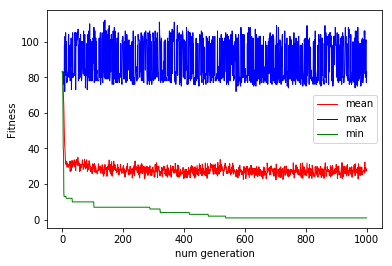

In [106]:
win, fit = ga.evolve()

In [107]:
print(c)
print(win)

0 - (U:758|A:elu|D:0.860) 
1 - (U:32|A:prelu|D:0.320) 
2 - (U:128|A:relu|D:0.500) 

0 - (U:758|A:elu|D:0.860) 
1 - (U:82|A:prelu|D:0.320) 
2 - (U:128|A:relu|D:0.500) 

